<Axes: >

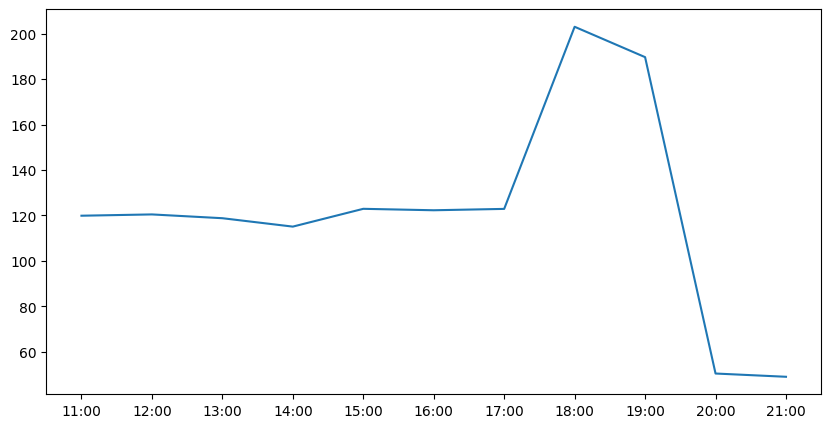

In [6]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

data = np.empty((30, 11), dtype=int)
for day in range(30):
    for hour in range(11):
        if hour <= 6:
            data[day, hour] = int(np.random.normal(120, 20))
        elif 6 < hour <= 8:
            data[day, hour] = int(np.random.normal(200, 30))
        else:
            data[day, hour] = int(np.random.normal(50, 10))

index = np.arange(11, 22, 1)
average_day = np.mean(data, axis=0)
ts = pd.Series(average_day, index=index)

plt.figure(figsize=(10, 5))
plt.xticks(index, [f"{i}:00" for i in index])

ts.plot()

In [11]:
from simpy import *

theater = Environment()

num_cashiers = 9
num_servers = 7
num_ushers = 4

wait_time = []

cashiers = Resource(theater, capacity=num_cashiers)
servers = Resource(theater, capacity=num_servers)
ushers = Resource(theater, capacity=num_ushers)

def buy_ticket(theater, customer):
    yield theater.timeout(max(np.random.normal(3, 1), 30 / 60))

def buy_food(theater, customer):
    yield theater.timeout(max(np.random.normal(3, 1), 1))

def check_ticket(theater, customer):
    yield theater.timeout(max(np.random.normal(3 / 60, 1 / 60), 1 / 60))

def go_to_movie(theater, customer, hour):
    arrival_time = theater.now

    with cashiers.request() as request:
        yield request
        yield theater.process(buy_ticket(theater, customer))

    if np.random.choice([True, False], p=[0.5,0.5]):
        with servers.request() as request:
            yield request
            yield theater.process(buy_food(theater, customer))

    with ushers.request() as request:
        yield request
        yield theater.process(check_ticket(theater, customer))

    total_time = theater.now - arrival_time

    if hour >= len(wait_time):
        wait_time.append([])

    wait_time[hour].append(total_time)

def run_theater(theater):
    customer = 0
    for hour in range(11):
        num_customers = np.random.poisson(average_day[hour])
        for i in range(num_customers):
            theater.process(go_to_movie(theater, customer, hour))
            customer += 1

            yield theater.timeout(np.random.exponential(60 / num_customers))

theater.process(run_theater(theater))
theater.run()

wait_time = [np.mean(wait_time[i]) for i in range(len(wait_time))]
wait_time

[4.565477818557674,
 4.636080188518033,
 4.2770116207980635,
 4.6123781996019595,
 4.54068319464128,
 5.023868085649099,
 4.983615688946833,
 4.915675990897079,
 7.9530483292302945,
 4.620454437317226,
 4.747386582659461]